In [1]:
!pip3 install swig > /dev/null 2>&1
!pip3 uninstall box2d-py -y > /dev/null 2>&1
!pip3 install box2d-py > /dev/null 2>&1
!pip3 install box2d box2d-kengz > /dev/null 2>&1
!apt install xvfb > /dev/null 2>&1
!pip3 install pyvirtualdisplay > /dev/null 2>&1
!pip3 install gym==0.25.0 > /dev/null 2>&1
!pip install gymnasium
!pip install stable_baselines3
!pip install gym[atari]
!pip install autorom[accept-rom-license]
!pip install mujoco
!pip install gymnasium-robotics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [2]:
# import gym
import random
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
import copy
from typing import Tuple
import gymnasium as gym
import ale_py
from gymnasium.wrappers import StepAPICompatibility

%matplotlib inline

In [3]:
# Replay buffer
class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.not_done = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, next_state, reward, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = 1. - done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.not_done[ind]).to(self.device)
		)


In [4]:
def dict_to_state(d):
    # print(d)
    # d = d[0]
    # print(d['observation'].shape)
    # print(d['achieved_goal'].shape)
    # print(d['desired_goal'].shape)
    # print(np.append(d['observation'], d['achieved_goal']))
    out = np.concatenate((np.concatenate((d['observation'], d['achieved_goal'])), d['desired_goal']))
    return out.astype('float32')

In [5]:
# Implementation of Deep Deterministic Policy Gradients (DDPG)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Actor_DDPG(nn.Module):
	def __init__(self, state_dim: int, action_dim: int, max_action: torch.tensor):
		super(Actor_DDPG, self).__init__()
		"""
		Inputs:
    state_dim: int, dimension of state
		action_dim: int, dimension of action
		Outputs:
		a torch.Tensor that represents future action
		"""
		# [HINT] Construct a neural network as the actor. Return its value using forward
		############################
		# YOUR IMPLEMENTATION HERE #
		self.fc1 = nn.Linear(state_dim, 128)
		self.fc2 = nn.Linear(128, 128)
		self.fc3 = nn.Linear(128, action_dim)
		############################
		self.max_action = max_action

	def forward(self, state):
		############################
		# YOUR IMPLEMENTATION HERE #
		a = F.relu(self.fc1(state))
		a = F.relu(self.fc2(a))
		return self.max_action * torch.tanh(self.fc3(a))
		############################

class Critic_DDPG(nn.Module):
	def __init__(self, state_dim: int, action_dim: int):
		super(Critic_DDPG, self).__init__()
		"""
    Inputs:
		same as the actor
		Outputs:
		torch.Tensor that represents the Q-values
		"""
		# [HINT] Construct a neural network as the critic. Return its value using forward
		############################
		# YOUR IMPLEMENTATION HERE #
		self.fc1 = nn.Linear(state_dim + action_dim, 128)
		self.fc2 = nn.Linear(128, 128)
		self.fc3 = nn.Linear(128, 1)
		############################

	def forward(self, state: torch.Tensor, action: torch.Tensor)->torch.Tensor:
		############################
		sa = torch.cat([state, action], 1)
		############################
		# YOUR IMPLEMENTATION HERE #
		q1 = F.relu(self.fc1(sa))
		q1 = F.relu(self.fc2(q1))
		q1 = self.fc3(q1)
		############################
		return q1

In [6]:
class DDPG(object):
	def __init__(self, state_dim: int, action_dim: int, max_action: float, discount=0.99, tau=0.001):
		# Initialize the models and the target models
		self.actor = Actor_DDPG(state_dim, action_dim, max_action).to(device)
		self.actor_target = copy.deepcopy(self.actor)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

		self.critic = Critic_DDPG(state_dim, action_dim).to(device)
		self.critic_target = copy.deepcopy(self.critic)
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

		self.discount = discount
		self.tau = tau


	def select_action(self, state):
		state = torch.FloatTensor(state.reshape(1, -1)).to(device)
		return self.actor(state).cpu().data.numpy().flatten()


	def train(self, replay_buffer, batch_size=64):
		# Sample from replay buffer
		state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

		# Compute the target_Q value with critic_target for the batch
		# [HINT] target_Q = reward + discount * Q_target(next_state) * not_done
		############################
		# YOUR IMPLEMENTATION HERE #
		target_Q = reward + self.discount * self.critic_target(next_state, self.actor_target(next_state)) * not_done
    ############################

		# Get current Q estimate
		current_Q = self.critic(state, action)

		# Compute critic loss
		# [HINT] It should be the an mse_loss or a mean of smooth_l1 function between current Q and target Q
		# [HINT] Remember that we should not update the target Q here! Detach the TD target to prevent gradient backprop
		############################
		# YOUR IMPLEMENTATION HERE #
		critic_loss = F.mse_loss(current_Q, target_Q.detach())
    ############################

		# Optimize the critic
		self.critic_optimizer.zero_grad()
		critic_loss.backward()
		self.critic_optimizer.step()

		# Compute actor loss
		# [HINT] You can easily compute the loss by critic(state, actor(state)).mean()
		############################
		# YOUR IMPLEMENTATION HERE #
		actor_loss = -self.critic(state, self.actor(state)).mean()
 		############################
		# Optimize the actor
		self.actor_optimizer.zero_grad()
		actor_loss.backward()
		self.actor_optimizer.step()

		# Update the target models
		# [HINT] You should calculate the weighted mean of every parameters between critic and critic_target,
		#        and the weighted mean of actor and actor_target. Store their values in new_target_params.
		# [HINT] The weight for the weighted mean is self.tau
		for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
      ############################
			# YOUR IMPLEMENTATION HERE #
			new_target_params = self.tau * param.data + (1 - self.tau) * target_param.data
			target_param.data.copy_(new_target_params)

		for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
			############################
			# YOUR IMPLEMENTATION HERE #
			new_target_params = self.tau * param.data + (1 - self.tau) * target_param.data
			target_param.data.copy_(new_target_params)

In [11]:
def init_flags():

    flags = {
        "env": "PointMaze_UMaze-v3",
        "seed":0, # random seed
        "start_timesteps": 25e3, #total steps of free exploration phase
        "max_timesteps": 2e5, # maximum length of time steps in training
        "expl_noise": 0.1, # noise strength in exploration
        "batch_size": 256,
        "discount":0.99,
        "tau": 0.005, # rate of target update
        "policy_noise": 0.2, # policy noise variance when sampling action
        "noise_clip":0.5, # noise clip rate
        "policy_freq": 2, # delayed policy update frequency in TD3
    }

    return flags

def main(policy_name = 'DDPG'):

    args = init_flags()
    env = gym.make(args["env"])
    # env = StepAPICompatibility(gym.make(args["env"]), False)
    # env.seed(args["seed"]+100)
    env.action_space.seed(args["seed"])
    torch.manual_seed(args["seed"])
    np.random.seed(args["seed"])
    # print(env.observation_space)
    state_dim = env.observation_space['observation'].shape[0] + env.observation_space['achieved_goal'].shape[0] + env.observation_space['desired_goal'].shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "discount": args["discount"],
        "tau": args["tau"],}
    if policy_name == "TD3":
        # Target policy smoothing is scaled wrt the action scale
        kwargs["policy_noise"] = args["policy_noise"] * max_action
        kwargs["noise_clip"] = args["noise_clip"] * max_action
        kwargs["policy_freq"] = args["policy_freq"]
        policy = TD3(**kwargs)
    elif policy_name == "DDPG":
        policy = DDPG(**kwargs)

    replay_buffer = ReplayBuffer(state_dim, action_dim)
    evaluations = []
    state, done = env.reset(), False
    state = dict_to_state(state[0])
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0

    for t in range(int(args["max_timesteps"])):

    #   print(t)
      episode_timesteps += 1

      # Select action randomly or according to policy
      if t < args["start_timesteps"]:
        action = env.action_space.sample()
      else:
        action = (
          policy.select_action(np.array(state))
          + np.random.normal(0, max_action * args["expl_noise"], size=action_dim)
        ).clip(-max_action, max_action)

      # Perform action
      next_state, reward, terminated, truncated, _ = env.step(action)
    #   print(terminated)
    #   print(truncated)
      next_state = dict_to_state(next_state)
      done_bool = float(truncated) if truncated else 0

      # Store data in replay buffer
      replay_buffer.add(state, action, next_state, reward, done_bool)
    #   print(replay_buffer.size)

      state = next_state
      episode_reward += reward
    #   print(episode_reward)

      # Train agent after collecting sufficient data
    #   print(args["start_timesteps"])
      if t >= args["start_timesteps"]:
        # print("training")
        policy.train(replay_buffer, args["batch_size"])

      if terminated or truncated:
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        evaluations.append(episode_reward)
        # Reset environment
        state, done = env.reset(), False
        state = dict_to_state(state[0])
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

    return evaluations


In [12]:
evaluations_ddpg = main(policy_name = 'DDPG')

Total T: 300 Episode Num: 1 Episode T: 300 Reward: 0.000
Total T: 600 Episode Num: 2 Episode T: 300 Reward: 0.000
Total T: 900 Episode Num: 3 Episode T: 300 Reward: 0.000
Total T: 1200 Episode Num: 4 Episode T: 300 Reward: 0.000
Total T: 1500 Episode Num: 5 Episode T: 300 Reward: 16.000
Total T: 1800 Episode Num: 6 Episode T: 300 Reward: 0.000
Total T: 2100 Episode Num: 7 Episode T: 300 Reward: 87.000
Total T: 2400 Episode Num: 8 Episode T: 300 Reward: 0.000
Total T: 2700 Episode Num: 9 Episode T: 300 Reward: 0.000
Total T: 3000 Episode Num: 10 Episode T: 300 Reward: 0.000
Total T: 3300 Episode Num: 11 Episode T: 300 Reward: 0.000
Total T: 3600 Episode Num: 12 Episode T: 300 Reward: 0.000
Total T: 3900 Episode Num: 13 Episode T: 300 Reward: 0.000
Total T: 4200 Episode Num: 14 Episode T: 300 Reward: 46.000
Total T: 4500 Episode Num: 15 Episode T: 300 Reward: 0.000
Total T: 4800 Episode Num: 16 Episode T: 300 Reward: 0.000
Total T: 5100 Episode Num: 17 Episode T: 300 Reward: 0.000
Total 

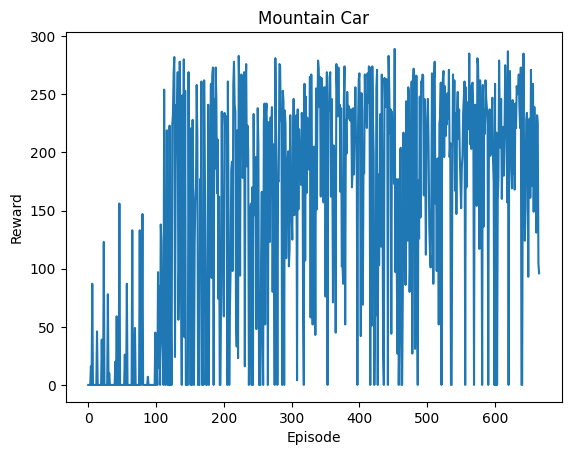

In [13]:
plt.title("Mountain Car")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(evaluations_ddpg)